In [1]:
%matplotlib inline

In [2]:
import dipy.reconst.dti as dti

import os
import numpy as np
import math
import SimpleITK as sitk
from scipy import ndimage
import nibabel as nib
from PIL import Image
import scipy.misc
from scipy import signal
import warnings
import SimpleITK as sitk
from dipy.reconst.dti import *

In [3]:
from ndreg import *
from dipy.tracking.eudx import EuDX
import networkx as nx

In [4]:
def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :], 90)
            else:
                image = im[:, :, pos]

            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig

def tiff_to_array(folder_path, input_path):
    """
    Function takes a single image (TIFF, or other also works), and returns
    the single image as a numpy array.  Called by tiff_stack_to_array.
    :param input_path: Single image file to open.
    :return: Numpy representation of image.
    """

    # The convert tag makes sure that we're dealing with floats, not uint8
    # This prevents underflow.
    im = Image.open(folder_path + input_path).convert("F")
    # im.show()

    imarray = np.array(im)
    # print(imarray)
    # print(imarray.dtype)
    
    return imarray


def tiff_stack_to_array(input_path):
    """
    Function takes input_path, which should should lead to a directory.
    Loads all TIFFs in input_path, then generates numpy arrays from the
    TIFF stack by calling tiff_to_array helper function.  Make sure TIFF
    images are ordered in numerical order.
    :param input_path: Folder or directory containing .tiff stack.
    :return: Numpy array of tiff stack.
    """
    im_list = [];
    for filename in os.listdir(input_path):
        if filename.endswith(".tif"):
            # print(os.path.join(directory, filename))
            im_arr = tiff_to_array(input_path, filename)
            im_list.append(im_arr)
        
    s = np.stack(im_list, axis=2)
    print s.shape
    return s

In [5]:
# A Python implementation of Ailey's matlab tensor code.

import os
import numpy as np
import math
import SimpleITK as sitk
from scipy import ndimage
import nibabel as nib
from PIL import Image
import scipy.misc
from scipy import signal
import warnings

def plot_rgb(im):
    plt.rcParams.update({'axes.labelsize': 'x-large',
                         'axes.titlesize': 'x-large'})

    if im.shape == (182, 218, 182):
        x = [78, 90, 100]
        y = [82, 107, 142]
        z = [88, 103, 107]
    else:
        shap = im.shape
        x = [int(shap[0]*0.35), int(shap[0]*0.51), int(shap[0]*0.65)]
        y = [int(shap[1]*0.35), int(shap[1]*0.51), int(shap[1]*0.65)]
        z = [int(shap[2]*0.35), int(shap[2]*0.51), int(shap[2]*0.65)]
    coords = (x, y, z)

    labs = ['Sagittal Slice (YZ fixed)',
            'Coronal Slice (XZ fixed)',
            'Axial Slice (XY fixed)']
    var = ['X', 'Y', 'Z']

    idx = 0
    for i, coord in enumerate(coords):
        for pos in coord:
            idx += 1
            ax = plt.subplot(3, 3, idx)
            ax.set_title(var[i] + " = " + str(pos))
            if i == 0:
                image = ndimage.rotate(im[pos, :, :,0:3], 90)
            elif i == 1:
                image = ndimage.rotate(im[:, pos, :,0:3], 90)
            else:
                image = im[:, :, pos,0:3]

            print image.shape
            if idx % 3 == 1:
                ax.set_ylabel(labs[i])
                ax.yaxis.set_ticks([0, image.shape[0]/2, image.shape[0] - 1])
                ax.xaxis.set_ticks([0, image.shape[1]/2, image.shape[1] - 1])

            plt.imshow(image)

    fig = plt.gcf()
    fig.set_size_inches(12.5, 10.5, forward=True)
    return fig


def fiber_stream(f):
    test = f
    print len(test)
    fig = plt.figure(1)
    plt.subplots(figsize=(10, 10))
    plt.subplot(311)
    plt.title("Y-axis vs X-axis (" + str(len(test)) + " fibers)")
    for i in range(len(test)):
        plt.plot(test[i][:,0], test[i][:,1])
    plt.subplot(312)
    plt.title("Z-axis vs X-axis (" + str(len(test)) + " fibers)")
    for i in range(len(test)):
        plt.plot(test[i][:,0], test[i][:,2])
    plt.subplot(313)
    plt.title("Z-axis vs Y-axis (" + str(len(test)) + " fibers)")
    for i in range(len(test)):
        plt.plot(test[i][:,1], test[i][:,2])
    plt.tight_layout()
    #fig = plt.show()
    fig.savefig('tensor_streamlines.png')


def tensor2tract(struct_tensor, is_fsl):
    if is_fsl:
        tmp = np.copy(struct_tensor[:,:,:,3])
        struct_tensor[:,:,:,3] = struct_tensor[:,:,:,2]
        struct_tensor[:,:,:,2] = tmp
    output = from_lower_triangular(struct_tensor)

    evals, evecs = decompose_tensor(output)

    FA = fractional_anisotropy(evals)

    RGB = color_fa(FA, evecs)
    # nb.save(nb.Nifti1Image(np.array(255 * RGB, 'uint8'), result.get_affine()), 'fsl_tensor_rgb_upper.nii.gz')

    affine = img.get_affine()
    fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
    im = fa.get_data()

    fig = plot_rgb(im)
    plt.savefig('tensor_field_brain.png')


    sphere = get_sphere('symmetric724')
    peak_indices = quantize_evecs(evecs, sphere.vertices)
    eu = EuDX(FA.astype('f8'), peak_indices, seeds=50000, odf_vertices = sphere.vertices, a_low=0.2)
    tensor_streamlines = [streamline for streamline in eu]
    return tensor_streamlines

# Step 1 registration

In [7]:
import tractography_latest as tract

In [131]:
shape = data.shape[:-1]
print np.asarray(shape).shape

(2,)


In [116]:
img = nib.load('/root/CTT/demo/result/data.nii.gz')
data = img.get_data()
labels = nib.load('/root/CTT/demo/result/mask-brain.nii.gz').get_data()

In [132]:
maskdata, mask = median_otsu(data, 3, 1, True,
                             vol_idx=range(10, 50), dilate=2)
print('maskdata.shape (%d, %d, %d)' % maskdata.shape)

maskdata.shape (90, 90, 90)


In [133]:
labels = maskdata

In [134]:
white_matter = (labels == 1) | (labels == 2)
affine = img.affine

In [135]:
from dipy.reconst.shm import CsaOdfModel
from dipy.data import default_sphere
from dipy.direction import peaks_from_model

csa_model = CsaOdfModel(gtab, sh_order=6)

In [136]:
csa_peaks = peaks_from_model(csa_model, data, default_sphere,
                             relative_peak_threshold=.8,
                             min_separation_angle=45,
                             mask=white_matter)

ValueError: Mask is not the same shape as data.

In [109]:
data = hardi_img.get_data()
labels = labels_img.get_data()

In [110]:
print data.shape

(81, 106, 76, 160)


In [89]:
import numpy as np
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

In [90]:
n_pts = 64
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)

In [91]:
hsph_updated, potential = disperse_charges(hsph_initial, 5000)

In [92]:
from dipy.core.gradients import gradient_table

vertices = hsph_updated.vertices
values = np.ones(vertices.shape[0])

In [93]:
bvecs = np.vstack((vertices, vertices))
bvals = np.hstack((1000 * values, 2500 * values))

In [95]:
gtab = gradient_table(bvals, bvecs)

In [ ]:
data = img.get_data()

from dipy.segment.mask import median_otsu

maskdata, mask = median_otsu(data, 3, 1, True,
                             vol_idx=range(10, 50), dilate=2)
print('maskdata.shape (%d, %d, %d)' % maskdata.shape)

In [103]:
maskdata = nib.load('/root/CTT/demo/result/mask-brain.nii.gz').get_data()

In [108]:
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(data)

ValueError: operands could not be broadcast together with remapped shapes [original->remapped]: (130,130)->(130,130) (8100,90)->(8100,newaxis,90) 

In [87]:
annoImg = imgRead('/root/CTT/demo/result/dog1gau0.5/ga.nii.gz')

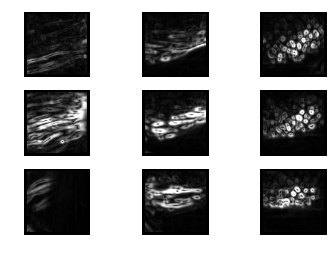

In [88]:
inThreshold = imgPercentile(annoImg, 0.99)
imgShow(annoImg, vmax=inThreshold)

In [66]:
    data = nib.read('')
    output = from_lower_triangular(data)
    #print output.shape

    FA = fractional_anisotropy(output)
    FA = np.clip(FA, 0, 1)
    FA[np.isnan(FA)] = 0
    #print FA.shape

    evalues, evectors = decompose_tensor(output)
    #print evectors[..., 0, 0].shape
    #print evectors.shape[-2:]

    RGB = color_fa(FA[:, :, :, 0], evectors)

    affine = img.affine

    fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
    im = fa.get_data()

    fig = plot_rgb(im)

IndexError: invalid index

In [10]:
rawImg = imgRead('/root/CTT/demo/result/data.nii.gz')

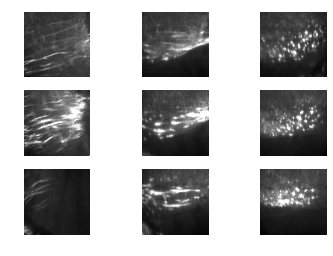

In [11]:
inThreshold = imgPercentile(rawImg, 0.99)
imgShow(rawImg, vmax=inThreshold)

In [17]:
#tensorimg = fear199tensor
tensorimg1 = nib.load('/root/CTT/demo/result/dog0.5gau0.5/dtk_tensor.nii.gz').get_data()
tensorimg2 = nib.load('/root/CTT/demo/result/dog1gau0.5/dtk_tensor.nii.gz').get_data()
tensorimg3 = nib.load('/root/CTT/demo/result/dog0.5gau1/dtk_tensor.nii.gz').get_data()
tensorimg4 = nib.load('/root/CTT/demo/result/dog1gau1/dtk_tensor.nii.gz').get_data()

In [18]:
tensorarray = [tensorimg1, tensorimg2, tensorimg3, tensorimg4]
for i in range (0, 3):
    data = tensorarray[i]
    print data.shape

(90, 90, 90, 6)
(90, 90, 90, 6)
(90, 90, 90, 6)


(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)


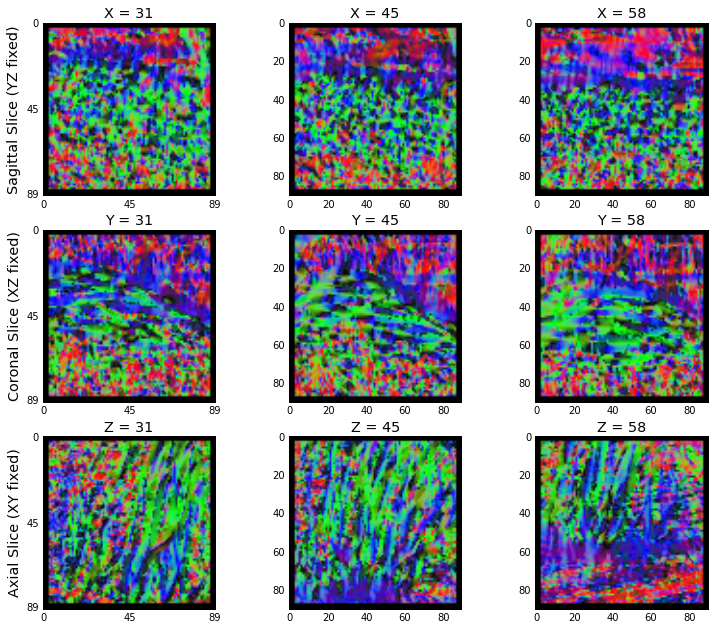

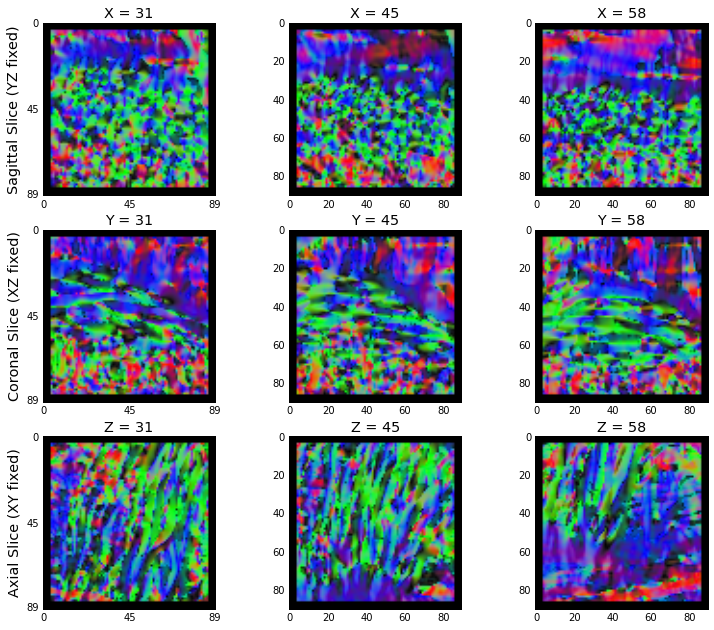

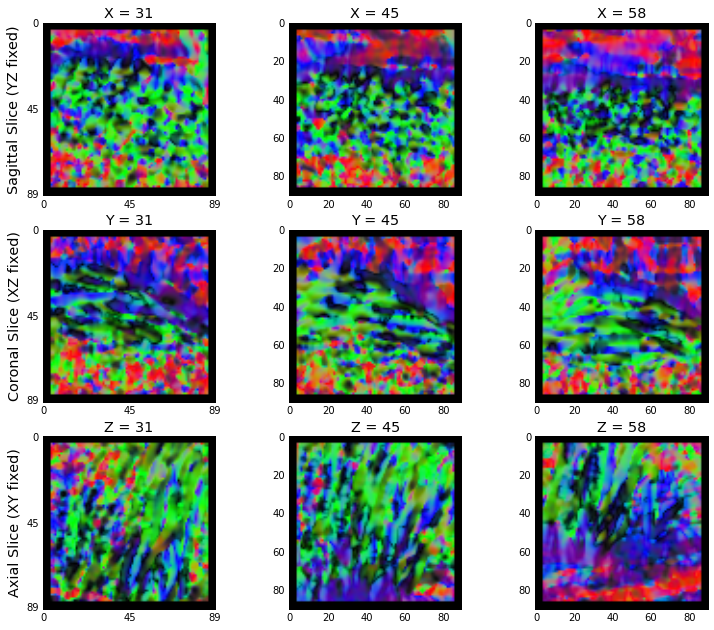

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [23]:
tensorarray = [tensorimg1, tensorimg2, tensorimg3, tensorimg4]

for i in range (0, 4):
    
    ####
    fig, axes = plt.subplots()
    axes.plot(range(10))
    ####
    
    data = tensorarray[i]
    output = from_lower_triangular(data)
    #print output.shape

    FA = fractional_anisotropy(output)
    FA = np.clip(FA, 0, 1)
    FA[np.isnan(FA)] = 0
    #print FA.shape

    evalues, evectors = decompose_tensor(output)
    #print evectors[..., 0, 0].shape
    #print evectors.shape[-2:]

    RGB = color_fa(FA[:, :, :, 0], evectors)

    affine = img.affine

    fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
    im = fa.get_data()

    fig = plot_rgb(im)

In [24]:
def tensor2tract(struct_tensor, is_fsl = False):
    if is_fsl:
        tmp = np.copy(struct_tensor[:,:,:,3])
        struct_tensor[:,:,:,3] = struct_tensor[:,:,:,2]
        struct_tensor[:,:,:,2] = tmp
    output = from_lower_triangular(struct_tensor)
    #output = output[300:500, 250:350, 400:800, :, :]

    
    evals, evecs = decompose_tensor(output)

    FA = fractional_anisotropy(evals)

    RGB = color_fa(FA, evecs)
    # nb.save(nb.Nifti1Image(np.array(255 * RGB, 'uint8'), result.get_affine()), 'fsl_tensor_rgb_upper.nii.gz')

    #affine = struct_tensor.get_affine()
    fa = nib.Nifti1Image(np.array(255 * RGB, 'uint8'), affine)
    im = fa.get_data()

    fig = plot_rgb(im)
    plt.savefig('tensor_field_brain.png')


    sphere = get_sphere('symmetric724')
    peak_indices = quantize_evecs(evecs, sphere.vertices)
    eu = EuDX(FA.astype('f8'), peak_indices, seeds=50000, odf_vertices = sphere.vertices, a_low=0.2)
    tensor_streamlines = [streamline for streamline in eu]
    return tensor_streamlines

(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)
(90, 90, 3)


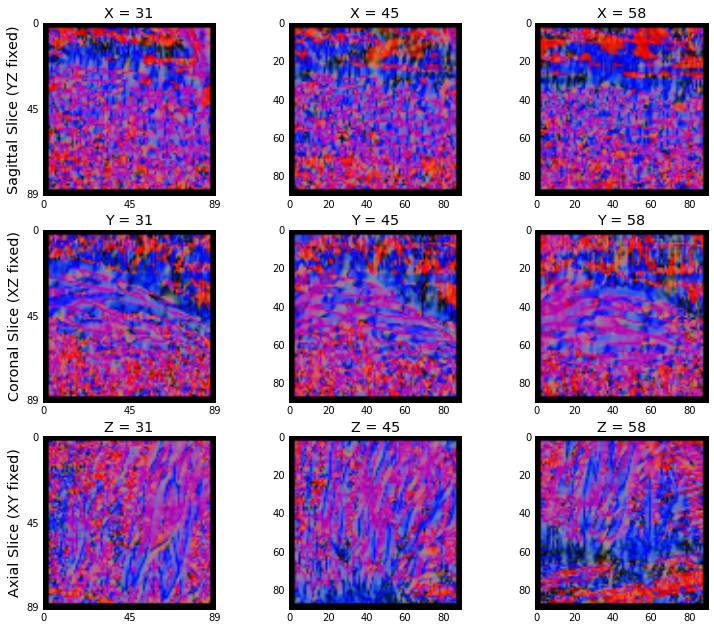

In [26]:
affine = img.affine

tensorimg = tensorimg1
streamlines = tensor2tract(tensorimg, False)

In [42]:
labels = nib.load('desikan.nii.gz').get_data()

In [43]:
from dipy.tracking import utils
M, grouping = utils.connectivity_matrix(streamlines, labels, affine=affine,
                                        return_mapping=True,
                                        mapping_as_streamlines=True)
M[:3, :] = 0
M[:, :3] = 0

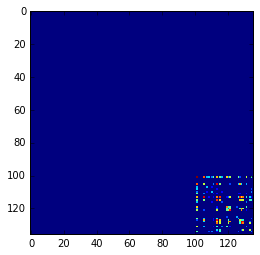

In [44]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(np.log1p(M), interpolation='nearest')

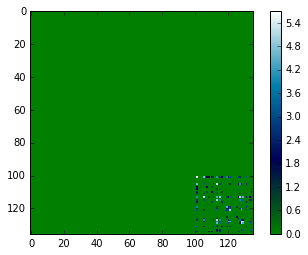

In [46]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')

plt.imshow(np.log1p(M), interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()